In [212]:
from dataset import LFWDataset # .py to load LFW dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
seed = 25

batch_size = 8
n_epochs = 200
learning_rate = 0.001

In [214]:
data = LFWDataset(
    faces_folder="../data/faces",
    smiling_labels_file="../data/SMILE_list.txt",
    non_smiling_labels_file="../data/NON-SMILE_list.txt",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),       # mean
                            (0.5, 0.5, 0.5))        # std
    ])
)

In [ ]:
# separate non-smiling faces and smiling faces
non_smiling_faces = [data[i] for i in range(len(data)) if data.labels[i] == 0]
len(non_smiling_faces)

603

In [ ]:
smiling_faces

In [216]:
# split dataset into train and validation sets
train_size = int(0.8 * len(non_smiling_faces))
train_dataset_0, test_dataset_0 = torch.utils.data.random_split(non_smiling_faces, [train_size, len(non_smiling_faces) - train_size], generator=torch.Generator().manual_seed(seed))


In [217]:
X_test = torch.stack([non_smiling_faces[i][0] for i in test_dataset_0.indices])
X_train = torch.stack([non_smiling_faces[i][0] for i in train_dataset_0.indices])

In [218]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
X_test = X_test.to(device)

In [219]:
train_dataset = TensorDataset(X_train, X_train)

val_size = int(0.15 * len(data))
train_data, val_data = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size], generator=torch.Generator().manual_seed(seed))

In [220]:
X_val = torch.stack([non_smiling_faces[i][0] for i in val_data.indices]).to(device)

In [221]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, X_test), batch_size=batch_size, shuffle=False)

In [222]:
def train_autoencoder(autoencoder, train_loader, val_loader, epochs=100, lr=0.01):
    """Train the autoencoder model."""
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder = autoencoder.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.L1Loss()
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #optimizer, factor=0.5, patience=5
#) # decaying lr
    
    # Training loop
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training
        autoencoder.train()
        train_loss = 0
        for batch_data, batch_targets in train_loader:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, batch_targets in val_loader:
                batch_data = batch_data.to(device)
                batch_targets = batch_targets.to(device)
                outputs = autoencoder(batch_data)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

        #scheduler.step(val_loss_avg)
    
    return train_losses, val_losses

In [223]:
def visualize_results(autoencoder, x_test, n=10):
    """Visualize original and reconstructed images."""
    # Encode and decode images from the test set.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()
    with torch.no_grad():
        decoded_imgs = autoencoder(x_test.to(device))

    # Convert to numpy for plotting (move to CPU first)
    x_test_np = (x_test.cpu().numpy() + 1) / 2
    decoded_imgs_np = (decoded_imgs.cpu().numpy() + 1) / 2

    # Plot the results
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [224]:
# Define the convolutional autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 64*64*3 --> 64*64*16
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # --> 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # --> 4*4*256
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # 4*4*256 --> 8*8*256
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 16*16*128
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 32*32*64
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1), # --> 32*32*32
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 64*64*32
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # --> 64*64*16
            nn.ReLU(),

            nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0), # --> 64*64*3
        )
        
        self.tanh = nn.Tanh()
    
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.tanh(decoded)
        return output


In [225]:
autoencoder = ConvAutoencoder()

train_losses, test_losses = train_autoencoder(autoencoder, train_loader, val_loader, epochs=n_epochs, lr=learning_rate)

Training Progress:   0%|          | 1/200 [00:00<01:30,  2.20it/s]

Epoch 1/200, Train Loss: 0.2110, Val Loss: 0.2003


Training Progress:   1%|          | 2/200 [00:00<01:04,  3.07it/s]

Epoch 2/200, Train Loss: 0.1769, Val Loss: 0.1792


Training Progress:   2%|▏         | 3/200 [00:00<00:54,  3.63it/s]

Epoch 3/200, Train Loss: 0.1647, Val Loss: 0.1682


Training Progress:   2%|▏         | 4/200 [00:01<00:59,  3.30it/s]

Epoch 4/200, Train Loss: 0.1583, Val Loss: 0.1557


Training Progress:   2%|▎         | 5/200 [00:01<00:56,  3.45it/s]

Epoch 5/200, Train Loss: 0.1660, Val Loss: 0.1541


Training Progress:   3%|▎         | 6/200 [00:01<00:53,  3.63it/s]

Epoch 6/200, Train Loss: 0.1560, Val Loss: 0.1555


Training Progress:   4%|▎         | 7/200 [00:02<00:51,  3.71it/s]

Epoch 7/200, Train Loss: 0.1632, Val Loss: 0.1535


Training Progress:   4%|▍         | 8/200 [00:02<00:50,  3.82it/s]

Epoch 8/200, Train Loss: 0.1472, Val Loss: 0.1401


Training Progress:   4%|▍         | 9/200 [00:02<00:49,  3.84it/s]

Epoch 9/200, Train Loss: 0.1476, Val Loss: 0.1458


Training Progress:   5%|▌         | 10/200 [00:02<00:47,  3.98it/s]

Epoch 10/200, Train Loss: 0.1431, Val Loss: 0.1311
Epoch 11/200, Train Loss: 0.1458, Val Loss: 0.1291


Training Progress:   6%|▌         | 12/200 [00:03<00:43,  4.30it/s]

Epoch 12/200, Train Loss: 0.1394, Val Loss: 0.1355


Training Progress:   6%|▋         | 13/200 [00:03<00:43,  4.35it/s]

Epoch 13/200, Train Loss: 0.1453, Val Loss: 0.1465


Training Progress:   7%|▋         | 14/200 [00:03<00:42,  4.42it/s]

Epoch 14/200, Train Loss: 0.1376, Val Loss: 0.1320


Training Progress:   8%|▊         | 15/200 [00:03<00:42,  4.39it/s]

Epoch 15/200, Train Loss: 0.1382, Val Loss: 0.1315


Training Progress:   8%|▊         | 16/200 [00:04<00:41,  4.48it/s]

Epoch 16/200, Train Loss: 0.1339, Val Loss: 0.1251


Training Progress:   8%|▊         | 17/200 [00:04<00:42,  4.31it/s]

Epoch 17/200, Train Loss: 0.1304, Val Loss: 0.1254


Training Progress:   9%|▉         | 18/200 [00:04<00:44,  4.11it/s]

Epoch 18/200, Train Loss: 0.1284, Val Loss: 0.1235


Training Progress:  10%|▉         | 19/200 [00:04<00:45,  3.96it/s]

Epoch 19/200, Train Loss: 0.1337, Val Loss: 0.1238


Training Progress:  10%|█         | 20/200 [00:05<00:50,  3.58it/s]

Epoch 20/200, Train Loss: 0.1329, Val Loss: 0.1255


Training Progress:  10%|█         | 21/200 [00:05<00:48,  3.69it/s]

Epoch 21/200, Train Loss: 0.1365, Val Loss: 0.1176


Training Progress:  11%|█         | 22/200 [00:05<00:45,  3.90it/s]

Epoch 22/200, Train Loss: 0.1302, Val Loss: 0.1262


Training Progress:  12%|█▏        | 23/200 [00:05<00:43,  4.05it/s]

Epoch 23/200, Train Loss: 0.1266, Val Loss: 0.1193


Training Progress:  12%|█▏        | 24/200 [00:06<00:52,  3.32it/s]

Epoch 24/200, Train Loss: 0.1249, Val Loss: 0.1196


Training Progress:  12%|█▎        | 25/200 [00:06<00:54,  3.22it/s]

Epoch 25/200, Train Loss: 0.1280, Val Loss: 0.1185


Training Progress:  13%|█▎        | 26/200 [00:06<00:52,  3.32it/s]

Epoch 26/200, Train Loss: 0.1278, Val Loss: 0.1219


Training Progress:  14%|█▎        | 27/200 [00:07<00:48,  3.56it/s]

Epoch 27/200, Train Loss: 0.1315, Val Loss: 0.1206


Training Progress:  14%|█▍        | 28/200 [00:07<00:47,  3.60it/s]

Epoch 28/200, Train Loss: 0.1286, Val Loss: 0.1169


Training Progress:  14%|█▍        | 29/200 [00:07<00:47,  3.63it/s]

Epoch 29/200, Train Loss: 0.1144, Val Loss: 0.1121


Training Progress:  15%|█▌        | 30/200 [00:07<00:46,  3.63it/s]

Epoch 30/200, Train Loss: 0.1264, Val Loss: 0.1259


Training Progress:  16%|█▌        | 31/200 [00:08<00:47,  3.55it/s]

Epoch 31/200, Train Loss: 0.1288, Val Loss: 0.1185


Training Progress:  16%|█▌        | 32/200 [00:08<00:51,  3.27it/s]

Epoch 32/200, Train Loss: 0.1230, Val Loss: 0.1268


Training Progress:  16%|█▋        | 33/200 [00:08<00:47,  3.53it/s]

Epoch 33/200, Train Loss: 0.1185, Val Loss: 0.1126


Training Progress:  17%|█▋        | 34/200 [00:09<00:47,  3.47it/s]

Epoch 34/200, Train Loss: 0.1228, Val Loss: 0.1161


Training Progress:  18%|█▊        | 35/200 [00:09<00:48,  3.37it/s]

Epoch 35/200, Train Loss: 0.1151, Val Loss: 0.1146


Training Progress:  18%|█▊        | 36/200 [00:09<00:46,  3.52it/s]

Epoch 36/200, Train Loss: 0.1180, Val Loss: 0.1115


Training Progress:  18%|█▊        | 37/200 [00:10<00:44,  3.65it/s]

Epoch 37/200, Train Loss: 0.1174, Val Loss: 0.1132


Training Progress:  19%|█▉        | 38/200 [00:10<00:42,  3.81it/s]

Epoch 38/200, Train Loss: 0.1139, Val Loss: 0.1078


Training Progress:  20%|█▉        | 39/200 [00:10<00:41,  3.88it/s]

Epoch 39/200, Train Loss: 0.1158, Val Loss: 0.1169


Training Progress:  20%|██        | 40/200 [00:10<00:42,  3.80it/s]

Epoch 40/200, Train Loss: 0.1080, Val Loss: 0.1068


Training Progress:  20%|██        | 41/200 [00:11<00:44,  3.54it/s]

Epoch 41/200, Train Loss: 0.1209, Val Loss: 0.1126


Training Progress:  21%|██        | 42/200 [00:11<00:41,  3.76it/s]

Epoch 42/200, Train Loss: 0.1106, Val Loss: 0.1042


Training Progress:  22%|██▏       | 43/200 [00:11<00:42,  3.66it/s]

Epoch 43/200, Train Loss: 0.1149, Val Loss: 0.1132


Training Progress:  22%|██▏       | 44/200 [00:11<00:43,  3.57it/s]

Epoch 44/200, Train Loss: 0.1147, Val Loss: 0.1130


Training Progress:  22%|██▎       | 45/200 [00:12<00:44,  3.50it/s]

Epoch 45/200, Train Loss: 0.1056, Val Loss: 0.1055


Training Progress:  23%|██▎       | 46/200 [00:12<00:45,  3.41it/s]

Epoch 46/200, Train Loss: 0.1071, Val Loss: 0.1110


Training Progress:  24%|██▎       | 47/200 [00:12<00:47,  3.19it/s]

Epoch 47/200, Train Loss: 0.1090, Val Loss: 0.1074


Training Progress:  24%|██▍       | 48/200 [00:13<00:48,  3.11it/s]

Epoch 48/200, Train Loss: 0.1108, Val Loss: 0.1068


Training Progress:  24%|██▍       | 49/200 [00:13<00:50,  2.97it/s]

Epoch 49/200, Train Loss: 0.1145, Val Loss: 0.1073


Training Progress:  25%|██▌       | 50/200 [00:14<00:53,  2.79it/s]

Epoch 50/200, Train Loss: 0.1064, Val Loss: 0.1122


Training Progress:  26%|██▌       | 51/200 [00:14<00:59,  2.50it/s]

Epoch 51/200, Train Loss: 0.1066, Val Loss: 0.1091


Training Progress:  26%|██▌       | 52/200 [00:14<01:02,  2.36it/s]

Epoch 52/200, Train Loss: 0.1034, Val Loss: 0.1200


Training Progress:  26%|██▋       | 53/200 [00:15<00:58,  2.51it/s]

Epoch 53/200, Train Loss: 0.1097, Val Loss: 0.1063


Training Progress:  27%|██▋       | 54/200 [00:15<00:53,  2.70it/s]

Epoch 54/200, Train Loss: 0.1097, Val Loss: 0.1083


Training Progress:  28%|██▊       | 55/200 [00:15<00:49,  2.90it/s]

Epoch 55/200, Train Loss: 0.1103, Val Loss: 0.1102


Training Progress:  28%|██▊       | 56/200 [00:16<00:46,  3.10it/s]

Epoch 56/200, Train Loss: 0.1068, Val Loss: 0.1101


Training Progress:  28%|██▊       | 57/200 [00:16<00:44,  3.18it/s]

Epoch 57/200, Train Loss: 0.1088, Val Loss: 0.1038


Training Progress:  29%|██▉       | 58/200 [00:16<00:42,  3.31it/s]

Epoch 58/200, Train Loss: 0.1032, Val Loss: 0.1071


Training Progress:  30%|██▉       | 59/200 [00:17<00:42,  3.33it/s]

Epoch 59/200, Train Loss: 0.1049, Val Loss: 0.1010


Training Progress:  30%|███       | 60/200 [00:17<00:40,  3.42it/s]

Epoch 60/200, Train Loss: 0.1043, Val Loss: 0.1049


Training Progress:  30%|███       | 61/200 [00:17<00:41,  3.32it/s]

Epoch 61/200, Train Loss: 0.0998, Val Loss: 0.1016


Training Progress:  31%|███       | 62/200 [00:17<00:39,  3.51it/s]

Epoch 62/200, Train Loss: 0.1029, Val Loss: 0.1064


Training Progress:  32%|███▏      | 63/200 [00:18<00:37,  3.66it/s]

Epoch 63/200, Train Loss: 0.0983, Val Loss: 0.1064


Training Progress:  32%|███▏      | 64/200 [00:18<00:36,  3.75it/s]

Epoch 64/200, Train Loss: 0.0987, Val Loss: 0.1016


Training Progress:  32%|███▎      | 65/200 [00:18<00:39,  3.46it/s]

Epoch 65/200, Train Loss: 0.0965, Val Loss: 0.1074


Training Progress:  33%|███▎      | 66/200 [00:18<00:37,  3.61it/s]

Epoch 66/200, Train Loss: 0.1051, Val Loss: 0.1194


Training Progress:  34%|███▎      | 67/200 [00:19<00:36,  3.64it/s]

Epoch 67/200, Train Loss: 0.1076, Val Loss: 0.1090


Training Progress:  34%|███▍      | 68/200 [00:19<00:35,  3.72it/s]

Epoch 68/200, Train Loss: 0.1014, Val Loss: 0.1013


Training Progress:  34%|███▍      | 69/200 [00:19<00:36,  3.55it/s]

Epoch 69/200, Train Loss: 0.1019, Val Loss: 0.1205


Training Progress:  35%|███▌      | 70/200 [00:20<00:35,  3.64it/s]

Epoch 70/200, Train Loss: 0.1011, Val Loss: 0.1042


Training Progress:  36%|███▌      | 71/200 [00:20<00:36,  3.55it/s]

Epoch 71/200, Train Loss: 0.0973, Val Loss: 0.1043


Training Progress:  36%|███▌      | 72/200 [00:20<00:38,  3.33it/s]

Epoch 72/200, Train Loss: 0.0952, Val Loss: 0.1052


Training Progress:  36%|███▋      | 73/200 [00:20<00:37,  3.38it/s]

Epoch 73/200, Train Loss: 0.1011, Val Loss: 0.1152


Training Progress:  37%|███▋      | 74/200 [00:21<00:36,  3.49it/s]

Epoch 74/200, Train Loss: 0.0963, Val Loss: 0.1010


Training Progress:  38%|███▊      | 75/200 [00:21<00:35,  3.57it/s]

Epoch 75/200, Train Loss: 0.0966, Val Loss: 0.1000


Training Progress:  38%|███▊      | 76/200 [00:21<00:34,  3.64it/s]

Epoch 76/200, Train Loss: 0.1023, Val Loss: 0.1125


Training Progress:  38%|███▊      | 77/200 [00:22<00:34,  3.58it/s]

Epoch 77/200, Train Loss: 0.0947, Val Loss: 0.1139


Training Progress:  39%|███▉      | 78/200 [00:22<00:38,  3.18it/s]

Epoch 78/200, Train Loss: 0.0984, Val Loss: 0.1029


Training Progress:  40%|███▉      | 79/200 [00:22<00:37,  3.19it/s]

Epoch 79/200, Train Loss: 0.0993, Val Loss: 0.1073


Training Progress:  40%|████      | 80/200 [00:23<00:38,  3.11it/s]

Epoch 80/200, Train Loss: 0.0977, Val Loss: 0.0993


Training Progress:  40%|████      | 81/200 [00:23<00:38,  3.06it/s]

Epoch 81/200, Train Loss: 0.0925, Val Loss: 0.1040


Training Progress:  41%|████      | 82/200 [00:23<00:37,  3.15it/s]

Epoch 82/200, Train Loss: 0.0933, Val Loss: 0.1027


Training Progress:  42%|████▏     | 83/200 [00:24<00:36,  3.22it/s]

Epoch 83/200, Train Loss: 0.0949, Val Loss: 0.1083


Training Progress:  42%|████▏     | 84/200 [00:24<00:35,  3.28it/s]

Epoch 84/200, Train Loss: 0.0960, Val Loss: 0.1033


Training Progress:  42%|████▎     | 85/200 [00:24<00:33,  3.45it/s]

Epoch 85/200, Train Loss: 0.0964, Val Loss: 0.1090


Training Progress:  43%|████▎     | 86/200 [00:24<00:32,  3.53it/s]

Epoch 86/200, Train Loss: 0.0973, Val Loss: 0.1011


Training Progress:  44%|████▎     | 87/200 [00:25<00:30,  3.65it/s]

Epoch 87/200, Train Loss: 0.0964, Val Loss: 0.1060


Training Progress:  44%|████▍     | 88/200 [00:25<00:31,  3.57it/s]

Epoch 88/200, Train Loss: 0.0913, Val Loss: 0.0993


Training Progress:  44%|████▍     | 89/200 [00:25<00:31,  3.51it/s]

Epoch 89/200, Train Loss: 0.0892, Val Loss: 0.0988


Training Progress:  45%|████▌     | 90/200 [00:25<00:31,  3.49it/s]

Epoch 90/200, Train Loss: 0.0880, Val Loss: 0.1022


Training Progress:  46%|████▌     | 91/200 [00:26<00:29,  3.65it/s]

Epoch 91/200, Train Loss: 0.0917, Val Loss: 0.1039


Training Progress:  46%|████▌     | 92/200 [00:26<00:30,  3.52it/s]

Epoch 92/200, Train Loss: 0.0865, Val Loss: 0.0994


Training Progress:  46%|████▋     | 93/200 [00:26<00:30,  3.51it/s]

Epoch 93/200, Train Loss: 0.0886, Val Loss: 0.1014


Training Progress:  47%|████▋     | 94/200 [00:27<00:29,  3.60it/s]

Epoch 94/200, Train Loss: 0.0922, Val Loss: 0.1047


Training Progress:  48%|████▊     | 95/200 [00:27<00:28,  3.69it/s]

Epoch 95/200, Train Loss: 0.0917, Val Loss: 0.1012


Training Progress:  48%|████▊     | 96/200 [00:27<00:27,  3.77it/s]

Epoch 96/200, Train Loss: 0.0909, Val Loss: 0.0999


Training Progress:  48%|████▊     | 97/200 [00:27<00:26,  3.92it/s]

Epoch 97/200, Train Loss: 0.0867, Val Loss: 0.1018


Training Progress:  49%|████▉     | 98/200 [00:28<00:27,  3.76it/s]

Epoch 98/200, Train Loss: 0.0866, Val Loss: 0.0988


Training Progress:  50%|████▉     | 99/200 [00:28<00:27,  3.71it/s]

Epoch 99/200, Train Loss: 0.0847, Val Loss: 0.1050


Training Progress:  50%|█████     | 100/200 [00:28<00:28,  3.45it/s]

Epoch 100/200, Train Loss: 0.0889, Val Loss: 0.1066


Training Progress:  50%|█████     | 101/200 [00:29<00:31,  3.19it/s]

Epoch 101/200, Train Loss: 0.0894, Val Loss: 0.1108


Training Progress:  51%|█████     | 102/200 [00:29<00:29,  3.30it/s]

Epoch 102/200, Train Loss: 0.0910, Val Loss: 0.1019


Training Progress:  52%|█████▏    | 103/200 [00:29<00:27,  3.49it/s]

Epoch 103/200, Train Loss: 0.0845, Val Loss: 0.1017


Training Progress:  52%|█████▏    | 104/200 [00:29<00:27,  3.51it/s]

Epoch 104/200, Train Loss: 0.0868, Val Loss: 0.0994


Training Progress:  52%|█████▎    | 105/200 [00:30<00:30,  3.10it/s]

Epoch 105/200, Train Loss: 0.0857, Val Loss: 0.0967


Training Progress:  53%|█████▎    | 106/200 [00:30<00:32,  2.88it/s]

Epoch 106/200, Train Loss: 0.0849, Val Loss: 0.0997


Training Progress:  54%|█████▎    | 107/200 [00:31<00:33,  2.79it/s]

Epoch 107/200, Train Loss: 0.0842, Val Loss: 0.1004


Training Progress:  54%|█████▍    | 108/200 [00:31<00:33,  2.78it/s]

Epoch 108/200, Train Loss: 0.0832, Val Loss: 0.1016


Training Progress:  55%|█████▍    | 109/200 [00:31<00:30,  3.00it/s]

Epoch 109/200, Train Loss: 0.0903, Val Loss: 0.1020


Training Progress:  55%|█████▌    | 110/200 [00:32<00:28,  3.14it/s]

Epoch 110/200, Train Loss: 0.0883, Val Loss: 0.1017


Training Progress:  56%|█████▌    | 111/200 [00:32<00:26,  3.36it/s]

Epoch 111/200, Train Loss: 0.0824, Val Loss: 0.0963


Training Progress:  56%|█████▌    | 112/200 [00:32<00:24,  3.54it/s]

Epoch 112/200, Train Loss: 0.0820, Val Loss: 0.0975


Training Progress:  56%|█████▋    | 113/200 [00:32<00:23,  3.73it/s]

Epoch 113/200, Train Loss: 0.0809, Val Loss: 0.0965


Training Progress:  57%|█████▋    | 114/200 [00:33<00:22,  3.84it/s]

Epoch 114/200, Train Loss: 0.0863, Val Loss: 0.1045


Training Progress:  57%|█████▊    | 115/200 [00:33<00:22,  3.71it/s]

Epoch 115/200, Train Loss: 0.0822, Val Loss: 0.0988


Training Progress:  58%|█████▊    | 116/200 [00:33<00:22,  3.79it/s]

Epoch 116/200, Train Loss: 0.0806, Val Loss: 0.1010


Training Progress:  58%|█████▊    | 117/200 [00:33<00:21,  3.91it/s]

Epoch 117/200, Train Loss: 0.0825, Val Loss: 0.1028


Training Progress:  59%|█████▉    | 118/200 [00:34<00:20,  3.98it/s]

Epoch 118/200, Train Loss: 0.0837, Val Loss: 0.1021


Training Progress:  60%|█████▉    | 119/200 [00:34<00:22,  3.52it/s]

Epoch 119/200, Train Loss: 0.0816, Val Loss: 0.0973


Training Progress:  60%|██████    | 120/200 [00:34<00:24,  3.22it/s]

Epoch 120/200, Train Loss: 0.0808, Val Loss: 0.0993


Training Progress:  60%|██████    | 121/200 [00:35<00:23,  3.40it/s]

Epoch 121/200, Train Loss: 0.0815, Val Loss: 0.0969


Training Progress:  61%|██████    | 122/200 [00:35<00:25,  3.00it/s]

Epoch 122/200, Train Loss: 0.0829, Val Loss: 0.1007


Training Progress:  62%|██████▏   | 123/200 [00:35<00:25,  3.06it/s]

Epoch 123/200, Train Loss: 0.0826, Val Loss: 0.1005


Training Progress:  62%|██████▏   | 124/200 [00:36<00:23,  3.26it/s]

Epoch 124/200, Train Loss: 0.0785, Val Loss: 0.0988


Training Progress:  62%|██████▎   | 125/200 [00:36<00:23,  3.22it/s]

Epoch 125/200, Train Loss: 0.0792, Val Loss: 0.0988


Training Progress:  64%|██████▎   | 127/200 [00:36<00:19,  3.70it/s]

Epoch 126/200, Train Loss: 0.0808, Val Loss: 0.0997
Epoch 127/200, Train Loss: 0.0802, Val Loss: 0.1051


Training Progress:  64%|██████▍   | 128/200 [00:37<00:18,  3.90it/s]

Epoch 128/200, Train Loss: 0.0820, Val Loss: 0.1018


Training Progress:  64%|██████▍   | 129/200 [00:37<00:19,  3.61it/s]

Epoch 129/200, Train Loss: 0.0806, Val Loss: 0.0971


Training Progress:  65%|██████▌   | 130/200 [00:37<00:19,  3.64it/s]

Epoch 130/200, Train Loss: 0.0801, Val Loss: 0.1008


Training Progress:  66%|██████▌   | 131/200 [00:37<00:20,  3.35it/s]

Epoch 131/200, Train Loss: 0.0797, Val Loss: 0.0973


Training Progress:  66%|██████▌   | 132/200 [00:38<00:22,  3.09it/s]

Epoch 132/200, Train Loss: 0.0798, Val Loss: 0.0970


Training Progress:  66%|██████▋   | 133/200 [00:38<00:23,  2.88it/s]

Epoch 133/200, Train Loss: 0.0831, Val Loss: 0.0974


Training Progress:  67%|██████▋   | 134/200 [00:39<00:21,  3.03it/s]

Epoch 134/200, Train Loss: 0.0800, Val Loss: 0.1003


Training Progress:  68%|██████▊   | 135/200 [00:39<00:20,  3.13it/s]

Epoch 135/200, Train Loss: 0.0791, Val Loss: 0.0959


Training Progress:  68%|██████▊   | 136/200 [00:39<00:20,  3.09it/s]

Epoch 136/200, Train Loss: 0.0764, Val Loss: 0.0987


Training Progress:  68%|██████▊   | 137/200 [00:39<00:20,  3.15it/s]

Epoch 137/200, Train Loss: 0.0787, Val Loss: 0.1005


Training Progress:  69%|██████▉   | 138/200 [00:40<00:20,  3.09it/s]

Epoch 138/200, Train Loss: 0.0822, Val Loss: 0.1039


Training Progress:  70%|██████▉   | 139/200 [00:40<00:20,  3.03it/s]

Epoch 139/200, Train Loss: 0.0802, Val Loss: 0.1022


Training Progress:  70%|███████   | 140/200 [00:40<00:19,  3.09it/s]

Epoch 140/200, Train Loss: 0.0779, Val Loss: 0.1027


Training Progress:  70%|███████   | 141/200 [00:41<00:19,  3.05it/s]

Epoch 141/200, Train Loss: 0.0797, Val Loss: 0.0971


Training Progress:  71%|███████   | 142/200 [00:41<00:19,  3.04it/s]

Epoch 142/200, Train Loss: 0.0787, Val Loss: 0.0983


Training Progress:  72%|███████▏  | 143/200 [00:41<00:18,  3.14it/s]

Epoch 143/200, Train Loss: 0.0786, Val Loss: 0.0969


Training Progress:  72%|███████▏  | 144/200 [00:42<00:16,  3.44it/s]

Epoch 144/200, Train Loss: 0.0780, Val Loss: 0.0993


Training Progress:  72%|███████▎  | 145/200 [00:42<00:16,  3.37it/s]

Epoch 145/200, Train Loss: 0.0791, Val Loss: 0.1009


Training Progress:  73%|███████▎  | 146/200 [00:42<00:16,  3.22it/s]

Epoch 146/200, Train Loss: 0.0792, Val Loss: 0.1006


Training Progress:  74%|███████▎  | 147/200 [00:43<00:16,  3.21it/s]

Epoch 147/200, Train Loss: 0.0768, Val Loss: 0.1003


Training Progress:  74%|███████▍  | 148/200 [00:43<00:15,  3.28it/s]

Epoch 148/200, Train Loss: 0.0785, Val Loss: 0.0981


Training Progress:  74%|███████▍  | 149/200 [00:43<00:14,  3.42it/s]

Epoch 149/200, Train Loss: 0.0763, Val Loss: 0.1054


Training Progress:  75%|███████▌  | 150/200 [00:43<00:14,  3.45it/s]

Epoch 150/200, Train Loss: 0.0778, Val Loss: 0.1012


Training Progress:  76%|███████▌  | 151/200 [00:44<00:13,  3.73it/s]

Epoch 151/200, Train Loss: 0.0788, Val Loss: 0.1035


Training Progress:  76%|███████▌  | 152/200 [00:44<00:12,  3.95it/s]

Epoch 152/200, Train Loss: 0.0755, Val Loss: 0.0965


Training Progress:  76%|███████▋  | 153/200 [00:44<00:12,  3.71it/s]

Epoch 153/200, Train Loss: 0.0764, Val Loss: 0.1026


Training Progress:  77%|███████▋  | 154/200 [00:44<00:12,  3.81it/s]

Epoch 154/200, Train Loss: 0.0756, Val Loss: 0.1017


Training Progress:  78%|███████▊  | 155/200 [00:45<00:11,  3.99it/s]

Epoch 155/200, Train Loss: 0.0768, Val Loss: 0.0999


Training Progress:  78%|███████▊  | 156/200 [00:45<00:10,  4.18it/s]

Epoch 156/200, Train Loss: 0.0761, Val Loss: 0.0998


Training Progress:  78%|███████▊  | 157/200 [00:45<00:10,  4.01it/s]

Epoch 157/200, Train Loss: 0.0769, Val Loss: 0.0977


Training Progress:  79%|███████▉  | 158/200 [00:45<00:10,  4.14it/s]

Epoch 158/200, Train Loss: 0.0751, Val Loss: 0.0959


Training Progress:  80%|███████▉  | 159/200 [00:46<00:09,  4.19it/s]

Epoch 159/200, Train Loss: 0.0749, Val Loss: 0.0983


Training Progress:  80%|████████  | 160/200 [00:46<00:09,  4.28it/s]

Epoch 160/200, Train Loss: 0.0743, Val Loss: 0.0962


Training Progress:  80%|████████  | 161/200 [00:46<00:08,  4.36it/s]

Epoch 161/200, Train Loss: 0.0730, Val Loss: 0.0980


Training Progress:  81%|████████  | 162/200 [00:46<00:08,  4.30it/s]

Epoch 162/200, Train Loss: 0.0747, Val Loss: 0.0972


Training Progress:  82%|████████▏ | 163/200 [00:47<00:08,  4.28it/s]

Epoch 163/200, Train Loss: 0.0740, Val Loss: 0.0971


Training Progress:  82%|████████▏ | 164/200 [00:47<00:08,  4.24it/s]

Epoch 164/200, Train Loss: 0.0744, Val Loss: 0.1004


Training Progress:  82%|████████▎ | 165/200 [00:47<00:09,  3.88it/s]

Epoch 165/200, Train Loss: 0.0735, Val Loss: 0.0972


Training Progress:  83%|████████▎ | 166/200 [00:47<00:09,  3.68it/s]

Epoch 166/200, Train Loss: 0.0737, Val Loss: 0.0973


Training Progress:  84%|████████▎ | 167/200 [00:48<00:09,  3.59it/s]

Epoch 167/200, Train Loss: 0.0760, Val Loss: 0.0993


Training Progress:  84%|████████▍ | 168/200 [00:48<00:08,  3.71it/s]

Epoch 168/200, Train Loss: 0.0750, Val Loss: 0.0983


Training Progress:  84%|████████▍ | 169/200 [00:48<00:08,  3.87it/s]

Epoch 169/200, Train Loss: 0.0742, Val Loss: 0.0988


Training Progress:  85%|████████▌ | 170/200 [00:48<00:07,  3.90it/s]

Epoch 170/200, Train Loss: 0.0754, Val Loss: 0.0996


Training Progress:  86%|████████▌ | 171/200 [00:49<00:07,  3.91it/s]

Epoch 171/200, Train Loss: 0.0750, Val Loss: 0.0971


Training Progress:  86%|████████▌ | 172/200 [00:49<00:06,  4.01it/s]

Epoch 172/200, Train Loss: 0.0754, Val Loss: 0.0993


Training Progress:  86%|████████▋ | 173/200 [00:49<00:06,  4.09it/s]

Epoch 173/200, Train Loss: 0.0733, Val Loss: 0.0986


Training Progress:  87%|████████▋ | 174/200 [00:49<00:06,  4.22it/s]

Epoch 174/200, Train Loss: 0.0777, Val Loss: 0.0995


Training Progress:  88%|████████▊ | 175/200 [00:50<00:05,  4.30it/s]

Epoch 175/200, Train Loss: 0.0751, Val Loss: 0.0990


Training Progress:  88%|████████▊ | 176/200 [00:50<00:05,  4.35it/s]

Epoch 176/200, Train Loss: 0.0736, Val Loss: 0.0976


Training Progress:  88%|████████▊ | 177/200 [00:50<00:05,  4.44it/s]

Epoch 177/200, Train Loss: 0.0749, Val Loss: 0.1053


Training Progress:  89%|████████▉ | 178/200 [00:50<00:05,  4.30it/s]

Epoch 178/200, Train Loss: 0.0763, Val Loss: 0.0985


Training Progress:  90%|████████▉ | 179/200 [00:50<00:04,  4.40it/s]

Epoch 179/200, Train Loss: 0.0717, Val Loss: 0.0993


Training Progress:  90%|█████████ | 180/200 [00:51<00:04,  4.44it/s]

Epoch 180/200, Train Loss: 0.0718, Val Loss: 0.0976


Training Progress:  90%|█████████ | 181/200 [00:51<00:04,  4.31it/s]

Epoch 181/200, Train Loss: 0.0741, Val Loss: 0.1005


Training Progress:  91%|█████████ | 182/200 [00:51<00:04,  4.32it/s]

Epoch 182/200, Train Loss: 0.0732, Val Loss: 0.1000


Training Progress:  92%|█████████▏| 183/200 [00:51<00:03,  4.39it/s]

Epoch 183/200, Train Loss: 0.0763, Val Loss: 0.0986


Training Progress:  92%|█████████▏| 184/200 [00:52<00:03,  4.46it/s]

Epoch 184/200, Train Loss: 0.0710, Val Loss: 0.1047


Training Progress:  92%|█████████▎| 185/200 [00:52<00:03,  4.52it/s]

Epoch 185/200, Train Loss: 0.0711, Val Loss: 0.1016


Training Progress:  93%|█████████▎| 186/200 [00:52<00:03,  4.56it/s]

Epoch 186/200, Train Loss: 0.0737, Val Loss: 0.1003


Training Progress:  94%|█████████▎| 187/200 [00:52<00:02,  4.38it/s]

Epoch 187/200, Train Loss: 0.0734, Val Loss: 0.0990


Training Progress:  94%|█████████▍| 188/200 [00:53<00:02,  4.46it/s]

Epoch 188/200, Train Loss: 0.0713, Val Loss: 0.1009


Training Progress:  94%|█████████▍| 189/200 [00:53<00:02,  4.51it/s]

Epoch 189/200, Train Loss: 0.0716, Val Loss: 0.1009


Training Progress:  95%|█████████▌| 190/200 [00:53<00:02,  4.46it/s]

Epoch 190/200, Train Loss: 0.0711, Val Loss: 0.0984


Training Progress:  96%|█████████▌| 191/200 [00:53<00:02,  4.36it/s]

Epoch 191/200, Train Loss: 0.0702, Val Loss: 0.1020


Training Progress:  96%|█████████▌| 192/200 [00:53<00:01,  4.35it/s]

Epoch 192/200, Train Loss: 0.0715, Val Loss: 0.0983


Training Progress:  96%|█████████▋| 193/200 [00:54<00:01,  3.96it/s]

Epoch 193/200, Train Loss: 0.0707, Val Loss: 0.0991


Training Progress:  97%|█████████▋| 194/200 [00:54<00:01,  4.00it/s]

Epoch 194/200, Train Loss: 0.0715, Val Loss: 0.1013


Training Progress:  98%|█████████▊| 195/200 [00:54<00:01,  4.11it/s]

Epoch 195/200, Train Loss: 0.0712, Val Loss: 0.0990


Training Progress:  98%|█████████▊| 196/200 [00:54<00:00,  4.07it/s]

Epoch 196/200, Train Loss: 0.0706, Val Loss: 0.1011


Training Progress:  98%|█████████▊| 197/200 [00:55<00:00,  4.12it/s]

Epoch 197/200, Train Loss: 0.0706, Val Loss: 0.0993


Training Progress:  99%|█████████▉| 198/200 [00:55<00:00,  3.95it/s]

Epoch 198/200, Train Loss: 0.0700, Val Loss: 0.1010


Training Progress: 100%|█████████▉| 199/200 [00:55<00:00,  4.05it/s]

Epoch 199/200, Train Loss: 0.0704, Val Loss: 0.0997


Training Progress: 100%|██████████| 200/200 [00:55<00:00,  3.58it/s]

Epoch 200/200, Train Loss: 0.0711, Val Loss: 0.0970


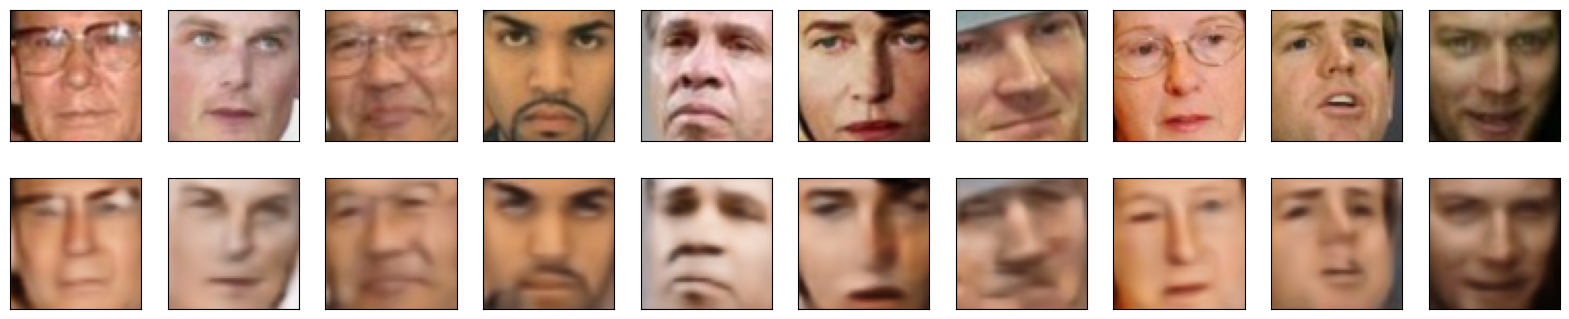

In [226]:
visualize_results(autoencoder, X_val)